# SIFT image alignment tutorial

SIFT (Scale-Invariant Feature Transform) is an algorithm developped by David Lowe in 1999. 
It is a worldwide reference for image alignment and object recognition. 
The robustness of this method enables to detect features at different scales, angles and illumination of a scene. 

Silx provides an implementation of SIFT in OpenCL, meaning that it can run on Graphics Processing Units and Central Processing Units as well. 
Interest points are detected in the image, then data structures called *descriptors* are built to be characteristic of the scene, so that two different images of the same scene have similar descriptors. 
They are robust to transformations like translation, rotation, rescaling and illumination change, which make SIFT interesting for image stitching. 

In the fist stage, descriptors are computed from the input images. 
Then, they are compared to determine the geometric transformation to apply in order to align the images. 
This implementation can run on most graphic cards and CPU, making it usable on many setups. 
OpenCL processes are handled from Python with PyOpenCL, a module to access OpenCL parallel computation API.

This tutuorial explains the three subsequent steps:

* keypoint extraction
* Keypoint matching
* image alignment

All the tutorial has been made using the Jupyter notebook.

In [1]:
import time
start_time = time.time()
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


Silx version 0.5.0-dev0


<IPython.core.display.Javascript object>


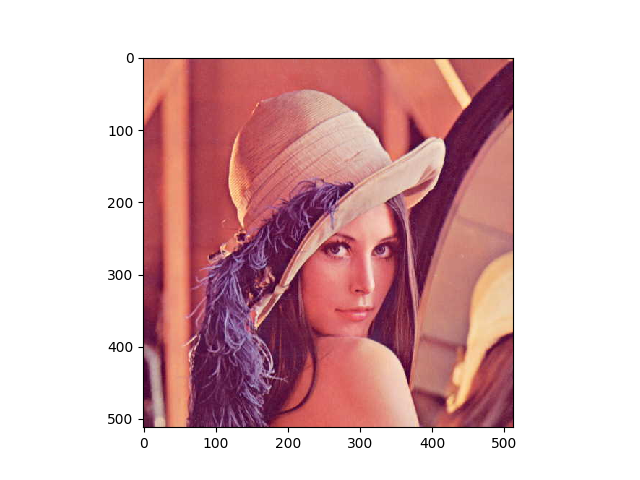

In [2]:
# display test image
import silx
print("Silx version %s"%silx.version)

from PIL import Image
from silx.test.utils import utilstest
path = utilstest.getfile("lena.png")
image = numpy.asarray(Image.open(path))
fig, ax = subplots()
ax.imshow(image, cmap="gray")

In [3]:
#Initialization of the sift object is time consuming: it compiles all the code.
import os 
#set to 1 to see the compilation going on
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "0" 
from silx.image import sift
#switch to "GPU" to "CPU" to enable fail-save version.
%time sift_ocl = sift.SiftPlan(template=image, devicetype="GPU") 

CPU times: user 112 ms, sys: 112 ms, total: 224 ms
Wall time: 240 ms


In [4]:
print("Time for calculating the keypoints on one image of size %sx%s"%image.shape[:2])
%time keypoints = sift_ocl(image)
print("Number of keypoints: %s"%len(keypoints))
print("Keypoint content:")
print(keypoints.dtype)
print("x: %.3f \t y: %.3f \t sigma: %.3f \t angle: %.3f" % 
      (keypoints[-1].x,keypoints[-1].y,keypoints[-1].scale,keypoints[-1].angle))
print("descriptor:")
print(keypoints[-1].desc)

Time for calculating the keypoints on one image of size 512x512
CPU times: user 652 ms, sys: 0 ns, total: 652 ms
Wall time: 649 ms
Number of keypoints: 411
Keypoint content:
(numpy.record, [('x', '<f4'), ('y', '<f4'), ('scale', '<f4'), ('angle', '<f4'), ('desc', 'u1', (128,))])
x: 275.483 	 y: 302.585 	 sigma: 36.518 	 angle: -0.194
descriptor:
[ 11   5   0   1   5  20  22   8  88  20   3   0   0   4  40 120  41   9
  13  52  32  36  15  81   1   8  14  25  89  84   7   1  12   0   0   0
  22  94  29   9 120  32   0   0   1  21  43  69  81  20   0   0  22 120
  43  49  48 120  13   2  16  79  17   3  24   6   0   0  30  76  16   9
 120  64   7   5   5  10   7  38  64  75  36  37  38  54   5   8 109 120
   9   1   2   4  12  21  39  22   0   0  18  19   5   4 120 120  10   5
   1   0   0   0  27  42  44  52  37  20   6   2  24  10   3   2   7  42
  81  25]


<IPython.core.display.Javascript object>


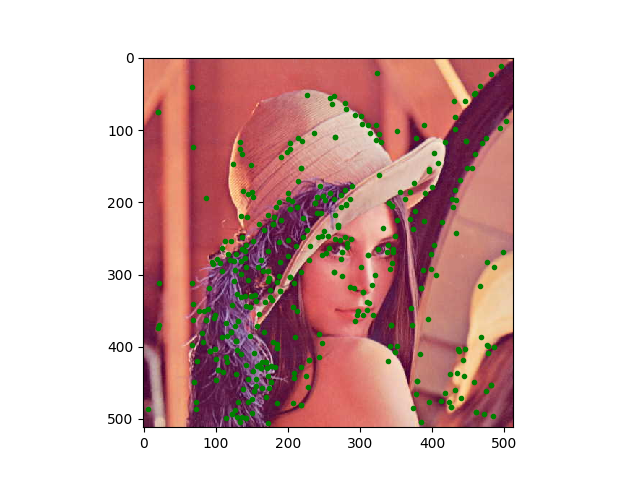

In [5]:
#Overlay keypoints on the image:
fig, ax = subplots()
ax.imshow(image)
ax.plot(keypoints[:].x, keypoints[:].y,".g")

<IPython.core.display.Javascript object>


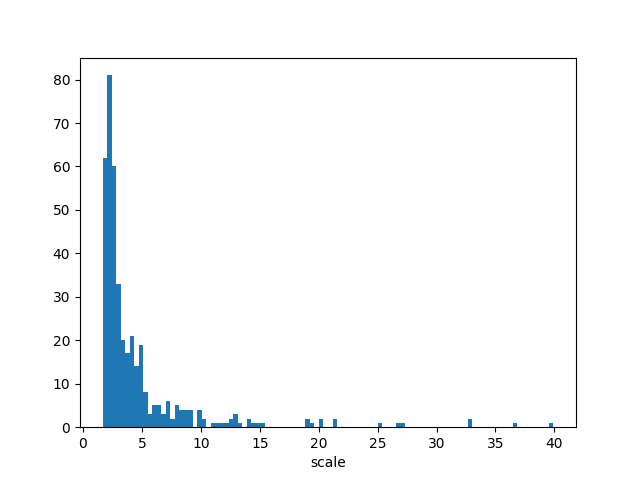

In [6]:
#Diplaying keypoints by scale:
fig, ax = subplots()
ax.hist(keypoints[:].scale, 100)
ax.set_xlabel("scale")

<IPython.core.display.Javascript object>


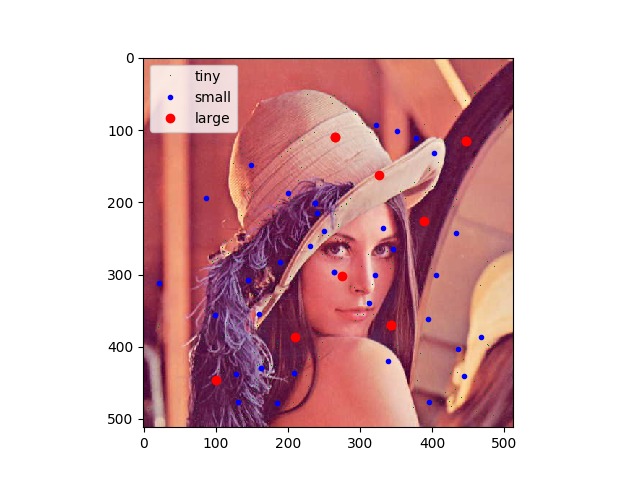

In [7]:
#One can see 3 groups of keypoints, boundaries at: 8 and 20. Let's display them using colors.
S = 8
L = 20
tiny = keypoints[keypoints[:].scale<S]
small = keypoints[numpy.logical_and(keypoints[:].scale<L,keypoints[:].scale>=S)]
bigger = keypoints[keypoints[:].scale>=L]

fig, ax = subplots()
ax.imshow(image, cmap="gray")
ax.plot(tiny[:].x, tiny[:].y,",g", label="tiny")
ax.plot(small[:].x, small[:].y,".b", label="small")
ax.plot(bigger[:].x, bigger[:].y,"or", label="large")
ax.legend()

## Image matching and alignment

Matching can also be performed on the device (GPU) as every single keypoint from an image needs to be compared with all
keypoints from the second image.

In this simple example we will simple offset the first image by a few pixels

In [8]:
shifted = numpy.zeros_like(image)
shifted[5:,8:] = image[:-5, :-8]
shifted_points = sift_ocl(shifted)

In [9]:
%time mp = sift.MatchPlan()
%time match = mp(keypoints, shifted_points)
print("Number of Keypoints with for image 1 : %i, For image 2 : %i, Matching keypoints: %i" % (keypoints.size, shifted_points.size, match.shape[0]))
from numpy import median
print("Measured offsets dx: %.3f, dy: %.3f"%(median(match[:,1].x-match[:,0].x),median(match[:,1].y-match[:,0].y)))

CPU times: user 20 ms, sys: 128 ms, total: 148 ms
Wall time: 167 ms
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 14.9 ms
Number of Keypoints with for image 1 : 411, For image 2 : 399, Matching keypoints: 351
Measured offsets dx: 8.000, dy: 5.000


/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/pyopencl/cffi_cl.py:1469: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


<IPython.core.display.Javascript object>


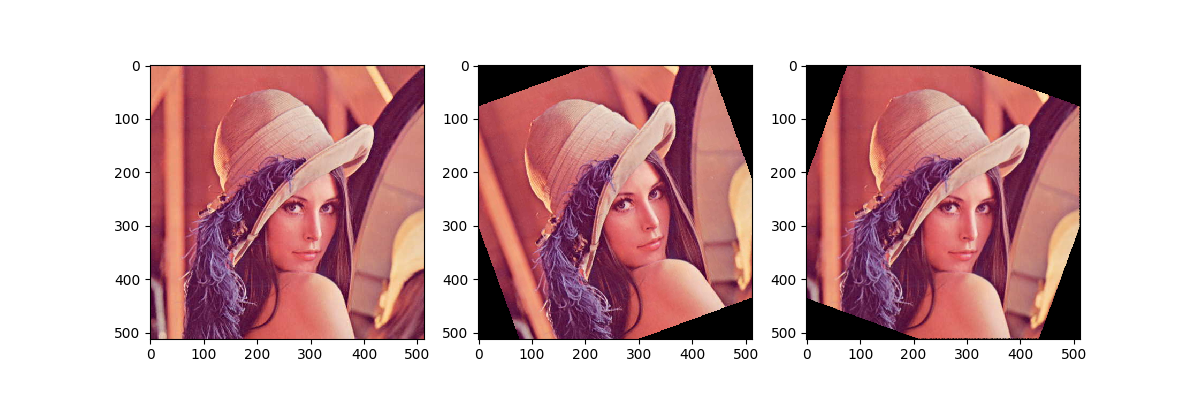

In [10]:
# Example of usage of the automatic alignment:
import scipy.ndimage
rotated = scipy.ndimage.rotate(image, 20, reshape=False)
sa = sift.LinearAlign(image)
fig,ax = subplots(1, 3, figsize=(12,4))
ax[0].imshow(image)
ax[1].imshow(rotated)
ax[2].imshow(sa.align(rotated))

### References

- David G. Lowe, Distinctive image features from scale-invariant keypoints, International Journal of Computer Vision, vol. 60, no 2, 2004, p. 91–110 - "http://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf"



In [11]:
print("Total execution time: %.3fs" % (time.time() - start_time))

Total execution time: 6.190s
